# English Text Data Analysis

* using avengers script data
* data import and wrangling
* tokenizing
* stop_words handling using stop_words 
* sentiment analysis using sentiments
* visualization and others

## library load

* 아래와 같은 패키지들을 load합니다.
* 모든 패키지가 다 사용되지 않을 수도 있습니다.
* 패키지가 설치되어야 로드될 수 있습니다.
* 패키지 설치는 아래의 명령어로 설치합니다.
> install.packages("패키지이름")

In [3]:
# dplyr grammar
library(tidyverse)
library(reshape2)
library(readtext)

# text analysis
library(stringr)
library(tidytext)
library(sentimentr)

# visualizationo
library(ggplot2)
library(wordcloud)
library(gridExtra)
library(ggthemes)

# network analysis
library(tidygraph)
library(ggraph)


## importing data

* 분석을 하려는 데이터를 가져옵니다.
* 데이터는 github에 올려두었습니다.
* 분석에 사용할 데이터는 2개입니다.
* 영화 avengers의 영문 시나리오 데이터입니다.
    * avengers 2: https://raw.githubusercontent.com/af2020/pnu/master/data/age_of_ultron_script_tab_sep.txt
    * avengers 3: https://raw.githubusercontent.com/af2020/pnu/master/data/infinity_war_script_tab_sep.txt


* 데이터를 가져오기 전에 먼저 텍스트 데이터를 열어서 확인해봅니다.
> * hero : 시나리오 상에서 대사를 하는 주인공 이름
> * script: 해당 주인공의 대사
* 이렇게 2개의 컬럼으로 구성되어 있고, 탭으로 구분되어 있습니다.

* tidytext 패키지를 이용하기 위해서는 데이터가 tibble 형식이어야 합니다.
* 데이터를 가져올 때, tibble 형식으로 가져오기 위해 read_delim() 함수를 이용합니다.
* read_delim() 함수는 사용자가 구분자를 지정할 수 있습니다.

* 데이터가 저장되어 있는 주소를 변수로 지정합니다.

In [5]:
# avengers 2 data url
a2_url <- 'https://raw.githubusercontent.com/af2020/pnu/master/data/age_of_ultron_script_tab_sep.txt'
# avengers 2 data url
a3_url <- 'https://raw.githubusercontent.com/af2020/pnu/master/data/infinity_war_script_tab_sep.txt'

* 데이터를 가져옵니다. 

In [118]:
read_delim(a2_url, delim='\t')

* 가져오려는 데이터의 각 컬럼의 type을 지정해주는 것이 좋습니다.
* 아래와 같이 가져올 수 있습니다.

In [17]:
a2 <- read_delim(a2_url, delim='\t', col_types=list(hero = col_character(), script = col_character()))
a3 <- read_delim(a3_url, delim='\t', col_types=list(hero = col_character(), script = col_character()))

* 데이터가 정상적으로 read 되었는지 살펴보겠습니다. 

In [119]:
a2  %>% tail(5)

hero,script,movie
Natasha Romanoff,"Let's beat 'em into shape. [they gather Rhodes in his War Machine suit, Sam in his Falcon suit, Wanda in a new suit, and Vision]",2
Steve Rogers,Avengers...!,2
**,"[mid-credits scene; we see the Infinity Gauntlet without any of the Stones, dissatisfied Thanos opens a vault and puts on The Infinty Gauntlet, revealing himself]",2
Thanos,"Fine, I'll do it myself.",2
**,[End of Avengers - Age of Ultron],2


## wrangling data

* avengers 2,3 데이터를 각각 a2, a3의 이름으로 read 했습니다.
* 분석을 위해서 데이터 처리를 해야 할 것이 있습니다.
    1. a2와 a3는 컬럼 구조가 같으므로 분석의 편의를 위해 하나의 데이터로 통합하려고 합니다.
    2. 현재 데이터에는 대화와 지문이 섞여 있습니다. 지문을 제외하고 대화만 추출하여 분석하려고 합니다.

### bind_rows()

* bind_rows() 함수를 이용하면 2개의 data frame을 행으로 합칠 수 있습니다.
* 다만, a2인지, a3인지를 구분해주는 dummy 컬럼이 있어야 합니다.

In [23]:
# dummy column add using mutate
a2 %>% mutate(movie = 2) -> a2
a3 %>% mutate(movie = 3) -> a3

* bind_rows() 이용해서 merge 합니다. 

In [25]:
bind_rows(a2, a3) -> a
# a2  %>% bind_rows(a3) -> a

* 제대로 합쳐졌는지 확인해보겠습니다. 

In [28]:
a  %>% tail(5)

hero,script,movie
**,"[*Fury then races back to their car and gets a what appears to be an old pager with extra gear attached out of his bag on the back seat. He sends out an emergency alert, mere seconds before his hand turns into ashes]*",3
**Nick Fury,"Oh, no. Motherf-",3
**,"[*Fury corrodes to dust. The pager falls to the ground, red lights blinking on the additions; the camera zooms in and we see the device display SENDING... then display a red-blue-and-gold star insignia -- the symbol of Captain Marvel.]*",3
------,NA,3
**,[*Screen title: Thanos will return]*,3


###  Extracting Dialogue

* 현재까지 구성한 데이터에서 분석을 하기 위해서는 추가적으로 데이터를 처리해야합니다.
    > * script 컬럼에 dialogue와 action이 섞여 있습니다. dialogue만 추출하여 분석하려고 합니다.
    > * regular expression (정규식)을 사용하여 문자 처리를 하려고 합니다.
    > * 원래 텍스트에 포함되어 있던 "*" 표시를 제외하려고 합니다.
    > * 또한 script 중간에 [  ] 표시로 적혀 있는 action script도 제외하려고 합니다.
    > * 각각의 script에 일련번호를 부여하려고 합니다.  

In [121]:
# without *
(
    a
    # hero preprocess
    %>% mutate(hero2 = str_replace_all(hero,"\\**", ""))
    %>% mutate(hero3 = str_replace_all(hero2, "F.R.I.D.A.Y.", "F.R.I.D.A.Y"))
    %>% mutate(hero4 = str_replace_all(hero3, "F.R.I.D.A.Y", "FRIDAY"))
    %>% mutate(hero5 = str_replace_all(hero4, "Thor'", "Thor"))
    %>% mutate(hero6 = str_trim(hero5))
    
    # script preprocess
    %>% mutate(script2 = str_replace_all(script,"\\*\\*\\*", ""))
    %>% mutate(script3 = str_replace_all(script2,"\\*\\*", ""))
    %>% mutate(script4 = str_replace_all(script3,"\\*", ""))
    
    # dialouge extract
    %>% mutate(script_wop = str_replace_all(script4,"\\[[a-zA-Z0-9 . , : ; ' - é ? � ( ) / ! % -]+\\]",""))
    
    # add index
    %>% mutate(id = row_number())
    
    # select columns
    %>% select(id, movie, hero = hero6, script = script4, dlg = script_wop)
    %>% head(5)
) # -> a

id,movie,hero,script,dlg
1,2,Announcer,[first lines; announcement over speaker] Report to your stations immediately. This is not a drill. We are under attack. We are under attack.,Report to your stations immediately. This is not a drill. We are under attack. We are under attack.
2,2,,"[the Avengers are in the process of infiltrating a HYDRA base in Sokovia, and Iron Man bounces off of the base's force field]",
3,2,Tony Stark,Shit!,Shit!
4,2,Steve Rogers,"Language! JARVIS, what's the view from upstairs?","Language! JARVIS, what's the view from upstairs?"
5,2,JARVIS,The central building is protected by some kind of energy shield. Strucker's technology is well beyond any other Hydra base we've taken.,The central building is protected by some kind of energy shield. Strucker's technology is well beyond any other Hydra base we've taken.


* 처리가 잘 되었는지 확인해보겠습니다.
* 대화를 추출한 dlg 컬럼에 지문을 표시하는 [ 혹은 ] 표시가 포함되어 있는지 여부를 확인합니다. 1

In [44]:
a %>% filter(str_detect(dlg, "\\]")) %>% summarise(n()) 

n()
0


* 아래와 같이 괄호를 사용하면 코멘트처리를 하면서 분석 결과를 쉽게 재확인할 수 있습니다. 
* summarise()만 제외하면 해당 데이터를 아래와 같이 직접확인할 수 있습니다. 

In [35]:
(
    a
    %>% filter(str_detect(dlg, "\\]"))
#     %>% summarise(n())
) 

id,movie,hero,script,dlg
1780,3,Rocket,"[to himself] Okay, time to be the captain. [walks to a console near by Thor], presses two buttons] So, dead brother, huh? Yeah, that can be annoying.","Okay, time to be the captain. , presses two buttons] So, dead brother, huh? Yeah, that can be annoying."


* 해당 텍스트를 찾아서 수동으로 변경해보겠습니다.
* str_replace() 함수를 이용했습니다.

In [41]:
(
    a
     %>% mutate(dlg2 = str_replace(dlg, ' , presses two buttons]',''))
) -> a

* 그리고, 새롭게 데이터를 구성합니다. 

In [43]:
a  %>% select(id, movie, hero, script, dlg = dlg2) -> a

* 완성된 데이터를 살펴보겠습니다. 

In [122]:
a  %>% head(5)

id,movie,hero,script,dlg
1,2,Announcer,[first lines; announcement over speaker] Report to your stations immediately. This is not a drill. We are under attack. We are under attack.,Report to your stations immediately. This is not a drill. We are under attack. We are under attack.
2,2,,"[the Avengers are in the process of infiltrating a HYDRA base in Sokovia, and Iron Man bounces off of the base's force field]",
3,2,Tony Stark,Shit!,Shit!
4,2,Steve Rogers,"Language! JARVIS, what's the view from upstairs?","Language! JARVIS, what's the view from upstairs?"
5,2,JARVIS,The central building is protected by some kind of energy shield. Strucker's technology is well beyond any other Hydra base we've taken.,The central building is protected by some kind of energy shield. Strucker's technology is well beyond any other Hydra base we've taken.


## tokenizing

* 각 hero들의 대화(dlg) 컬럼의 텍스트를 분석하려고 합니다.
* dlg 컬럼의 script를 단어 단위로 구분하여 데이터를 만들려고 합니다.
* tidytext package의 tokenize를 사용합니다.

In [47]:
(
    a
    %>% select(id, movie, hero, dlg)
    %>% unnest_tokens(word, dlg)
    
)  -> a_dlg_word

In [49]:
a_dlg_word  %>% head(3)

id,movie,hero,word
1,2,Announcer,report
1,2,Announcer,to
1,2,Announcer,your


* 가장 많이 등장하는, 빈도수가 가장 높은 단어는 무엇일까요? avengers 1편과 2편을 합쳐서 통계를 내보겠습니다.

In [52]:
a_dlg_word %>% count(word, sort=TRUE)  %>% head(10)

word,n
the,731
you,678
i,557
to,446
a,409
it,306
is,237
of,230
and,229
we,220


* 대부분이 의미없는 단어들입니다.
* stop words를 통해서 이런 단어들을 걸러내야 할 필요성이 있습니다. 

## handling stop words 

* tokenize 된 word 중에는 의미없는 단어들이 포함되어 있습니다.
* 분석에 방해가 되는 정보이므로 제거하려고 합니다.
* 영문 stop words를 사용하면 이 작업을 수월하게 할 수 있습니다. 
* tidytext 패키지에서 제공하는 stop_words 사전을 살펴보겠습니다. 

In [54]:
stop_words  %>% head(5)

word,lexicon
a,SMART
a's,SMART
able,SMART
about,SMART
above,SMART


* 이제 stop_words에 있는 단어를 제외해보겠습니다. 
* stop_words를 제외한 후에 빈도를 다시 계산해보겠습니다. 

In [67]:
(
    a_dlg_word
     %>% anti_join(stop_words, by='word') 
     %>% count(word, sort=TRUE)
     %>% head(10)
)

word,n
yeah,66
time,63
stone,53
gonna,52
stark,45
thanos,44
ultron,37
hey,29
life,29
uh,28


* stop_words에 추가하기

In [68]:
my_stop_words <- tibble(word = c('yeah', 'gonna', 'wanna', 'hey', 'gotta'), lexicon="custom")

In [75]:
stop_words %>% bind_rows(my_stop_words) -> stop_words_custom # %>% tail(10)#  -> stop_words_custome

In [77]:
stop_words_custom  %>% tail(10)

word,lexicon
young,onix
younger,onix
youngest,onix
your,onix
yours,onix
yeah,custom
gonna,custom
wanna,custom
hey,custom
gotta,custom


* stop_words에서 제외하기

In [76]:
stop_words_custom %>% filter(word != "gonna")  %>% tail(10)# -> stop_words_wo_yeah

word,lexicon
you,onix
young,onix
younger,onix
youngest,onix
your,onix
yours,onix
yeah,custom
wanna,custom
hey,custom
gotta,custom


## creating hero list

* 대화를 분석해서 hero 별로 결과를 보고 싶습니다.
* 이를 위해서 hero list가 있어야 합니다.
* a 데이터에서 hero 를 추출해보겠습니다. 

* 먼저 hero 컬럼이 비어 있지 않아야 합니다. 공백으로 값이 없는 경우도 있고, 공백인 경우도 있습니다. 
* 이렇게 행을 추출하고, hero 컬럼에서 고유값을 행갯수와 함께 뽑아보겠습니다. 

In [81]:
(
    a
    %>% filter(str_length(hero)!= 0)
    %>% filter(hero != ' ')
    %>% group_by(hero)
    %>% summarise(cnt = n())
#     %>% summarise(distinct = n_distinct(hero))
    %>% arrange(desc(cnt))
#     %>% filter(cnt >= 15)
    
)  -> hero_list

## analysis topic 01 - fining too much talker

* what is the definition of 'too much talker'?
* my definition of too much talker : average number of word in a script is high
* we can use sentence index and word frequency
* but we should use original script

In [99]:
(
    
    a_dlg_word
    %>% group_by(id, movie, hero)
    %>% summarise(word_cnt = n())
    
    #############################################
    # condition for word cnt for each script
#     %>% filter(word_cnt >= 15)
    #############################################
            
    %>% group_by(movie, hero)
    %>% summarise(id_cnt = n_distinct(id), word_sum=sum(word_cnt), word_avg = word_sum/id_cnt) 
    %>% arrange(desc(word_avg))
    
    # condition for script cnt for each hero
    %>% filter(id_cnt>=5)
    %>% filter(movie == 2)
    
    #############################################
#     visualization
    #############################################
    
#     %>% select(movie, hero, word_avg)
#     %>% head(30)
#     %>% ggplot()
#     + geom_bar(aes(x=reorder(hero,word_avg), y=word_avg), stat='identity')
#     + coord_flip()


)

movie,hero,id_cnt,word_sum,word_avg
2,Ulysses Klaue,7,190,27.142857
2,Iron Legion,5,76,15.200000
2,Ultron,81,1216,15.012346
2,Nick Fury,26,378,14.538462
2,Dr. Helen Cho,18,234,13.000000
2,Tony Stark,179,2179,12.173184
2,Vision,19,230,12.105263
2,Strucker,12,137,11.416667
2,Laura Barton,16,181,11.312500
2,Thor,56,624,11.142857


* 결과에 대해서 이런 생각을 해볼 수 있습니다.
* 평균에 근거했기 때문에 발생할 수 있는 문제는 없을까?
* 예를 들면, 문장 갯수가 많지만, 대부분의 문장이 짧은 반응이었다면 실제 의미있는 문장이 길었다고 해도 평균은 짧아질것
* hero 별 문장 길이의 분포를 분석하고 이를 근거로 계산해야 의미있는 것이 될 것
* 원래 script에서 문장에 포함된 단어의 갯수가 적은 것은 제외하고 분석에 포함해야 한다는 것을 확인할 수 있습니다. 


In [89]:
(
    a
    %>% inner_join(a_dlg_word %>% group_by(id) %>% summarise(word_cnt=n()))
    %>% filter(hero == "Peter Parker")
    %>% filter(word_cnt >= 15)
)

Joining, by = "id"


id,movie,hero,script,dlg,word_cnt
1677,3,Peter Parker,But it was such a long way down and I just thought about you on the way...,But it was such a long way down and I just thought about you on the way...,17
1680,3,Peter Parker,"...And I kinda stuck to the side of the ship. And this suit is ridiculously intuitive, by the way. So if anything, it's kinda your fault that I'm here.","...And I kinda stuck to the side of the ship. And this suit is ridiculously intuitive, by the way. So if anything, it's kinda your fault that I'm here.",29
1687,3,Peter Parker,"It's just- You can't be a friendly neighborhood Spider-Man when there's no neighborhood. [he waits for Iron Man's reaction] Okay. That didn't really make any sense, but you know what I'm trying to say.","It's just- You can't be a friendly neighborhood Spider-Man when there's no neighborhood. Okay. That didn't really make any sense, but you know what I'm trying to say.",29
1845,3,Peter Parker,"Let me just say, if aliens wind up implanting eggs in my chest or something, and I end up eating you, I'm sorry.","Let me just say, if aliens wind up implanting eggs in my chest or something, and I end up eating you, I'm sorry.",23
2311,3,Peter Parker,"[stumbling and terrified] I don't know what's- I don't know what's happening. I don't- [Parker falls into Stark's arms, clutching him tight and crying] Save me, save me! I don't wanna go, I don't wanna go, sir, please. Please, I don't wanna go. I don't wanna go... I'm sorry. [Parker disintegrates into ashes in Stark's arms]","I don't know what's- I don't know what's happening. I don't- Save me, save me! I don't wanna go, I don't wanna go, sir, please. Please, I don't wanna go. I don't wanna go... I'm sorry.",36


* word_cnt의 분포를 살펴보겠습니다. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


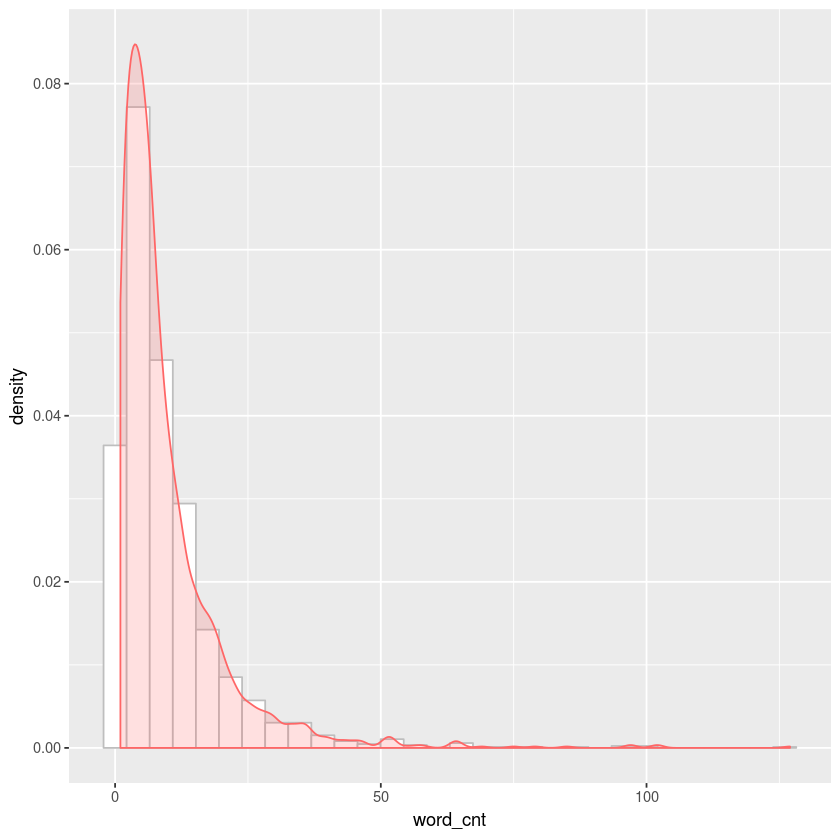

In [90]:
(
    a_dlg_word
    %>% group_by(id, movie, hero)
    %>% summarise(word_cnt = n())
#     %>% filter(word_cnt >10)
    %>% ggplot(aes(x=word_cnt))
#     + geom_histogram(binwidth=1) 
    + geom_histogram(aes(y=..density..), fill="white", color = "gray") 
    + geom_density(alpha=0.2, fill = "#FF6666", color="#FF6666" )
    
)

* hero별로 분포가 다르지 않을까요? 

Joining, by = "hero"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


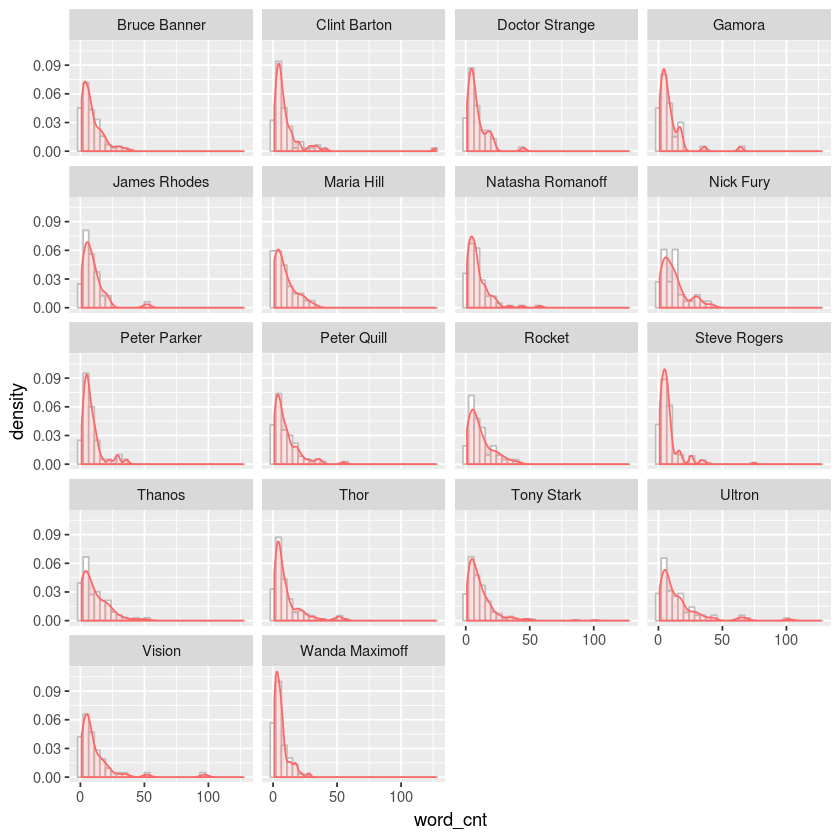

In [97]:

(
    a_dlg_word
    %>% group_by(id, movie, hero)
    %>% summarise(word_cnt = n())
    %>% arrange(hero)
    %>% inner_join(hero_list %>% filter(cnt >= 30))
    %>% ggplot(aes(x=word_cnt)) 
#     + geom_histogram(binwidth=1) 
    + geom_histogram(aes(y=..density..), fill="white", color = "gray") 
    + geom_density(alpha=0.2, fill = "#FF6666", color="#FF6666" )
    + facet_wrap(~hero, ncol=4)
    
#     %>% head(5)
)

* 분포를 고려해볼 때, 최소한 문장당 몇글자 이상인 경우로 분석 대상을 한정해야 할까요? 

## analysis topic 02 - word cloud

Joining, by = "word"


NULL

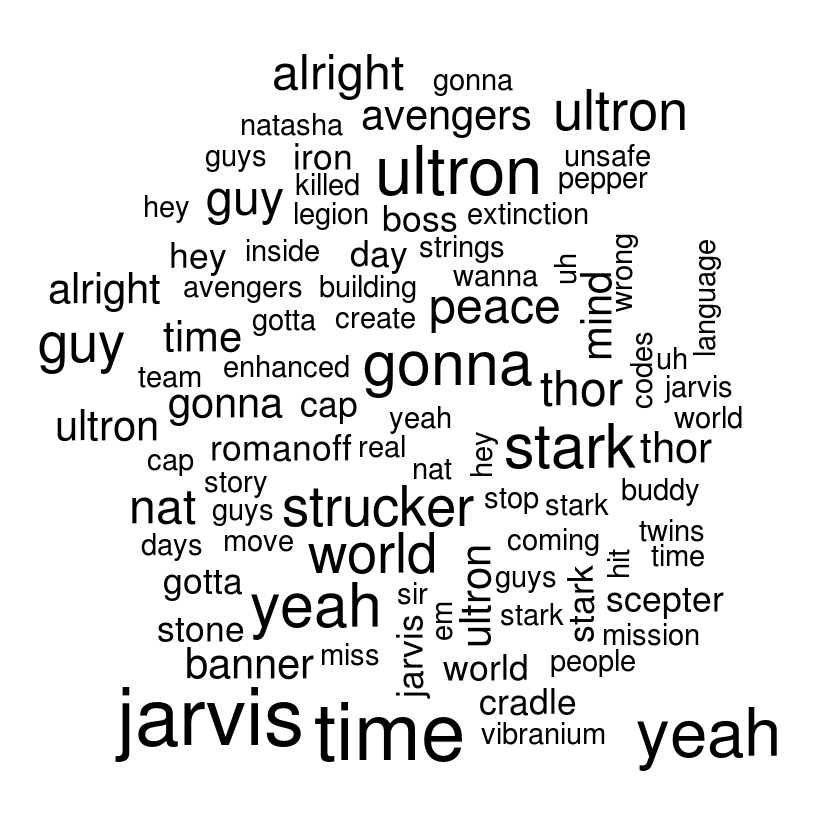

In [101]:
(
    a_dlg_word
    %>% anti_join(stop_words)
#     %>% inner_join(hero_list %>% arrange(desc(cnt)) %>% head(10))
    %>% group_by(movie, hero, word)
    %>% summarise(word_cnt=n_distinct(id))
    %>% arrange(desc(word_cnt))
    
#     %>% filter(hero == "Steve Rogers")
    %>% filter(movie == 2)
   
    %>% with(wordcloud(word, word_cnt, max.words=100))
#     %>% head(5)
)

## analyis topic 03 - dialogue network

* hero간 대화를 나타내는 네트워크를 구성합니다.

In [103]:
(
    a
    %>% left_join(a_dlg_word %>% group_by(id) %>% summarise(word_cnt = n()))
    %>% mutate(hero_lead_01= lead(hero))
    %>% mutate(hero_lead_02=lead(hero_lead_01))
    %>% filter(hero == hero_lead_02)
    %>% filter(hero != '' & hero_lead_01 != '' & hero_lead_02 !='')
    %>% select(hero_source = hero, hero_target = hero_lead_01, id, movie, word_cnt, dlg)
#     %>% select(hero_source = hero, hero_target, id, movie, word_cnt,dlg)
#     %>% filter(hero_source != '' & hero_target != '')
    
) -> a_g

Joining, by = "id"


In [104]:
(
    a_g
    %>% select(hero_source, hero_target, word_cnt)
#     %>% select(hero_source, hero_target)
    %>% as_tbl_graph(directed=FALSE)
    %>% activate(nodes)
    %>% mutate(neighbors = centrality_degree())
    %>% arrange(desc(neighbors))
    %>% as.tibble()
    %>% head(10)
)


Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”

name,neighbors
Tony Stark,287
Bruce Banner,126
Steve Rogers,122
Thor,101
Ultron,86
Natasha Romanoff,85
Wanda Maximoff,71
Thanos,70
Peter Quill,69
Clint Barton,55


* 그래프 데이터로 layout을 구합니다. 

In [105]:
create_layout(
    a_g %>% 
    select(hero_source, hero_target, word_cnt) %>% 
    as_tbl_graph(directed=TRUE), layout="fr") -> layout


* 시각화를 수행합니다. 

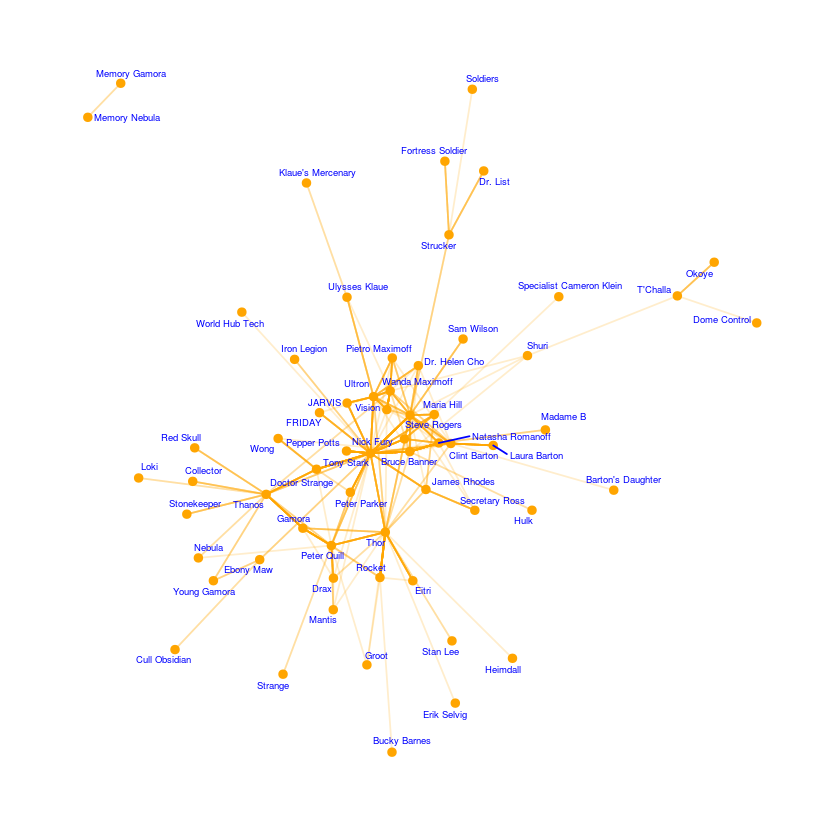

In [106]:
(
    ggraph(layout)
#     + geom_edge_density(aes(fill=word_cnt))
#     + geom_edge_link(aes(width=word_cnt), alpha = 0.2)
    + geom_edge_link(color="orange", alpha = 0.2)
#     + geom_edge_link(alpha = 0.2, width=2)
    + geom_node_point(color= 'orange', size=2)
    + geom_node_text(aes(label=name), color = "blue", size=2, repel=TRUE)
#     + scale_color_brewer(palette = "Set1")
    + theme_graph()
)

## analysis topic 04 - sentiment analysis

* tidytext package에서 제공하는 sentiment dictionary를 이용하려고 합니다. 
* 어떻게 구성되어 있는지 살펴봅시다. 

In [108]:
(
    sentiments
#     %>% distinct(lexicon)
#     %>% filter(lexicon == 'nrc') %>% distinct(sentiment)
#     %>% filter(lexicon == 'AFINN') %>% distinct(score) %>% arrange(score)
    %>% filter(lexicon=="bing") %>% distinct(sentiment) 
#     %>% filter(lexicon == "loughran") %>% distinct(sentiment)
)


sentiment
negative
positive


* 분석대상 데이터의 word 에 sentiment 사전의 결과를 컬럼 추가합니다. 

Joining, by = "word"
Joining, by = c("word", "lexicon")
Joining, by = "hero"


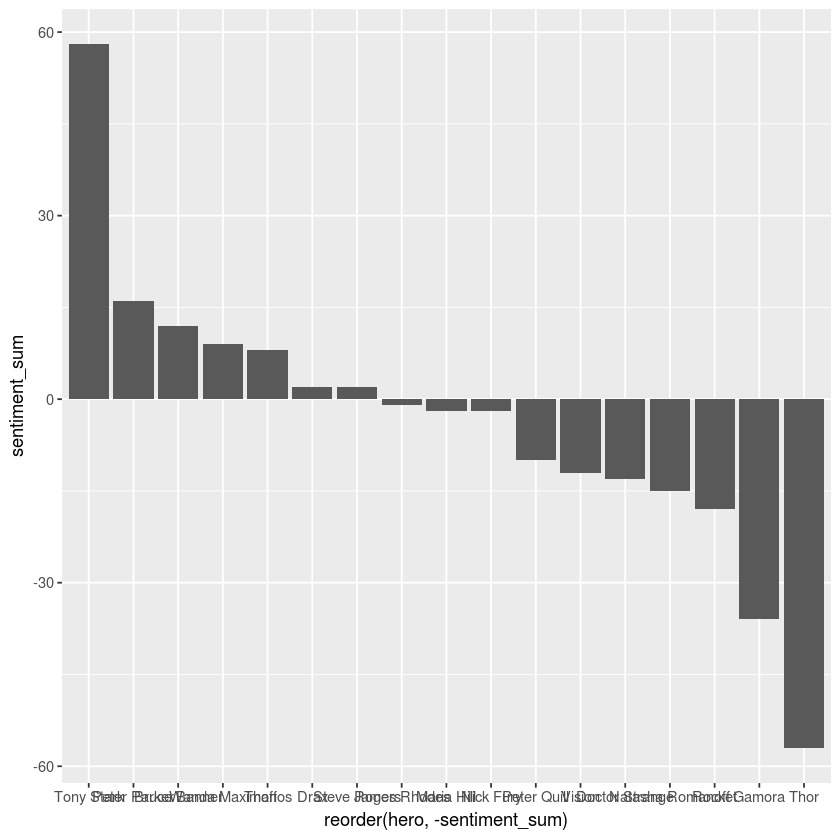

In [112]:
(
    a_dlg_word
    %>% inner_join(sentiments)
    %>% anti_join(stop_words)
    %>% inner_join(hero_list %>% arrange(desc(cnt)) %>% head(20))
    
    %>% filter(lexicon == "AFINN")
    %>% group_by(movie, hero)
    %>% summarise(sentiment_sum = sum(score))
    %>% arrange(desc(sentiment_sum))
    
    %>% filter(movie == 3)
    
    ################################
    ## visualiation
    ################################
    %>% ggplot()
    + geom_bar(aes(x=reorder(hero, -sentiment_sum), y=sentiment_sum), stat="identity")
)

* nrc sentiment dictionary를 사용하면 단어에 감정의 종류를 분여할 수 있습니다.

In [116]:
(
    a_dlg_word
    %>% inner_join(sentiments)
    %>% anti_join(stop_words)
    %>% inner_join(hero_list %>% arrange(desc(cnt)) %>% head(20))
    
    %>% filter(lexicon == "nrc")
    
    %>% group_by(movie, hero,sentiment, word)
    %>% summarise(id_cnt = n_distinct(id))
    
    %>% group_by(movie, sentiment, hero)
    %>% summarise(sentiment_word_sum = sum(id_cnt))

    %>% arrange(desc(sentiment_word_sum))
    %>% top_n(5)
    %>% filter(movie == 3)
    %>% filter(sentiment  == 'trust')
    
    ################################
    ## visualiation
    ################################
    
#     %>% ggplot()
#     + geom_bar(aes(x=reorder(hero, sentiment_word_sum), y=sentiment_word_sum), stat="identity")
#     + coord_flip()
#     + facet_wrap(~ sentiment, ncol=2)
# #     %>% head(10)
)

Joining, by = "word"
Joining, by = c("word", "lexicon")
Joining, by = "hero"
Selecting by sentiment_word_sum


movie,sentiment,hero,sentiment_word_sum
3,trust,Thor,29
3,trust,Tony Stark,27
3,trust,Thanos,22
3,trust,Peter Quill,19
3,trust,Doctor Strange,13
3,trust,Peter Parker,13
